# Distributed Computing and Fugue

<img src="https://miro.medium.com/max/1400/0*QgMjc3vz7_twxzjh" alt="image info" width="700"/>

## Why Do I Need Distributed Compute?

1. Pandas being single-core
2. Intermediate copies of [Pandas DataFrames](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html#scaling-to-large-datasets)
3. Limited to vertical scaling

<img src="https://ml.dask.org/_images/dimensions_of_scale.svg" alt="image info" width="700"/>

## Components of Distributed Compute

This Dask [issue](https://github.com/dask/dask/issues/4471) contains some diagrams that show the distributed computing architecture.

<img src="https://user-images.githubusercontent.com/11656932/62263986-bbba2f00-b3e3-11e9-9b5c-8446ba4efcf9.png" align="left" width="700"/>

Dask has collections that build on top of the standard PyData stack. For example, a Dask DataFrame is comprised of multiple Pandas DataFrames.

<img src="https://docs.dask.org/en/latest/_images/dask-dataframe.svg" align="left" width="400"/>

## [Reference on Partitions](https://blog.scottlogic.com/2018/03/22/apache-spark-performance.html) by Scott Logic

This reference has a lot of good images and explanations

### Ideal Partitioning Strategy
![Partitioning](https://blog.scottlogic.com/mdebeneducci/assets/Ideal-Partitioning.png)
### Skewed Partitions
![Skewed Partitions](https://blog.scottlogic.com/mdebeneducci/assets/Skewed-Partitions.png)
### Inefficient Scheduling
![Inefficient Scheduling](https://blog.scottlogic.com/mdebeneducci/assets/Inefficient-Scheduling.png)
### Data Shuffling
![Shuffle](https://blog.scottlogic.com/mdebeneducci/assets/Shuffle-Diagram.png)

In [1]:
import warnings
warnings.simplefilter("ignore")

from typing import Iterator, Any, Union, List, Dict
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/02 03:17:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## First Look at Dask and Spark

In [2]:
import warnings
warnings.simplefilter("ignore")

**Simple Problem - ML Inference**

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

X = pd.DataFrame({"x_1": [1, 1, 2, 2], "x_2":[1, 2, 2, 3]})
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)

In [4]:
def predict(df: pd.DataFrame, model: LinearRegression) -> pd.DataFrame:
    return df.assign(predicted=model.predict(df))

input_df = pd.DataFrame({"x_1": [3, 4, 6, 6], "x_2":[3, 3, 6, 6]})

# test the function
predict(input_df.copy(), reg)

,x_1,x_2,predicted
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


**Bring it to Dask (map_partitions)**

In [5]:
import dask.dataframe as dd

dask_df = dd.from_pandas(input_df, npartitions=2)

In [6]:
ddf = dask_df.map_partitions(predict, reg)
ddf.compute().head()

,x_1,x_2,predicted
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


**Bringing it to Spark (mapInPandas)**

In [7]:
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.sql import DataFrame

def predict_wrapper(dfs: Iterator[pd.DataFrame], model):
    for df in dfs:
        yield predict(df, model)

def run_predict(input_df: Union[DataFrame, pd.DataFrame], model):
    # conversion
    if isinstance(input_df, pd.DataFrame):
        sdf = spark.createDataFrame(input_df.copy())
    else:
        sdf = input_df.copy()

    schema = StructType(list(sdf.schema.fields))
    schema.add(StructField("predicted", DoubleType()))
    return sdf.mapInPandas(lambda dfs: predict_wrapper(dfs, model), 
                           schema=schema)

result = run_predict(input_df.copy(), reg)
result.show()

+---+---+---------+
|x_1|x_2|predicted|
+---+---+---------+
|  3|  3|     12.0|
|  4|  3|     13.0|
|  6|  6|     21.0|
|  6|  6|     21.0|
+---+---+---------+



**Bring it to Dask and Spark with Fugue**

In [8]:
from fugue import transform

result = transform(
    input_df.copy(),
    predict,
    schema="*,predicted:double",
    params=dict(model=reg),
)
result.head()

,x_1,x_2,predicted
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


In [9]:
import fugue_dask

result = transform(
    input_df.copy(),
    predict,
    schema="*,predicted:double",
    params=dict(model=reg),
    engine="dask"
)
print(type(result))
result.compute().head()

<class 'dask.dataframe.core.DataFrame'>


,x_1,x_2,predicted
0,3,3,12.0
0,4,3,13.0
0,6,6,21.0
0,6,6,21.0


In [10]:
import fugue_spark

result = transform(
    input_df.copy(),
    predict,
    schema="*,predicted:double",
    params=dict(model=reg),
    engine="spark"
)
print(type(result))
result.show()

<class 'pyspark.sql.dataframe.DataFrame'>


/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/triad/utils/pandas_like.py:247: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return isinstance(df.index, (pd.RangeIndex, pd.Int64Index, pd.UInt64Index))
/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/triad/utils/pandas_like.py:247: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return isinstance(df.index, (pd.RangeIndex, pd.Int64Index, pd.UInt64Index))
/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/triad/utils/pandas_like.py:247: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return isinstance(df.index, (pd.RangeIndex, pd.Int64Index, pd.UInt64Index))
/opt/miniconda3

+---+---+---------+
|x_1|x_2|predicted|
+---+---+---------+
|  3|  3|     12.0|
|  4|  3|     13.0|
|  6|  6|     21.0|
|  6|  6|     21.0|
+---+---+---------+



/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/triad/utils/pandas_like.py:247: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return isinstance(df.index, (pd.RangeIndex, pd.Int64Index, pd.UInt64Index))
/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/triad/utils/pandas_like.py:247: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return isinstance(df.index, (pd.RangeIndex, pd.Int64Index, pd.UInt64Index))
/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/triad/utils/pandas_like.py:247: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return isinstance(df.index, (pd.RangeIndex, pd.Int64Index, pd.UInt64Index))
/opt/miniconda3

**Slight edit to the function**

When x_2 = 0, predict x_1 + x_2

In [11]:
from typing import List, Dict, Any
def predict_row(df: List[Dict[str,Any]], model: LinearRegression) -> List[Dict[str,Any]]:
    for row in df:
        if row["x_2"] == 3:
            row["predicted"] = row["x_1"] + row["x_2"]
        else:
            row["predicted"] = float(model.predict([list(row.values())])[0])
    return df

In [12]:
predict_row([{"x_1": 3, "x_2":3}], reg)

[{'x_1': 3, 'x_2': 3, 'predicted': 6}]

**Type flexibility of Fugue**

In [13]:
result = transform(
    input_df.copy(),
    predict_row,
    schema="*,predicted:double",
    params=dict(model=reg),
    engine="dask"
)
result.head()

,x_1,x_2,predicted
0,3,3,6.0


In [14]:
result = transform(
    input_df,
    predict_row,
    schema="*,predicted:double",
    params=dict(model=reg),
    engine="spark"
)
print(type(result))
result.show()

<class 'pyspark.sql.dataframe.DataFrame'>


/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


+---+---+---------+
|x_1|x_2|predicted|
+---+---+---------+
|  3|  3|      6.0|
|  4|  3|      7.0|
|  6|  6|     21.0|
|  6|  6|     21.0|
+---+---+---------+



/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### FugueSQL Quick Look

In [15]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

In [16]:
# schema: *
def predict(df: pd.DataFrame, n: int) -> pd.DataFrame:
    return df.assign(predicted=reg.predict(df)+n)

In [17]:
%%fsql
SELECT *
  FROM input_df
 WHERE x_1 >= 4
TRANSFORM USING predict(n=1)
 PRINT

,x_1,x_2
0,4,3
1,6,6
2,6,6


In [18]:
%%fsql dask
SELECT *
  FROM input_df
 WHERE x_1 >= 4
TRANSFORM USING predict(n=1)
 PRINT

,x_1,x_2
0,4,3
1,6,6
2,6,6


## Distributed Compute Pitfalls

**Inefficient Partitioning**

In [19]:
from time import sleep

def delay(df:pd.DataFrame) -> pd.DataFrame:
    sleep(df.shape[0]*3)
    return df.assign(b=df.shape[0])

In [20]:
%%time
pdf = pd.DataFrame([[0],[1],[2],[3],[4],[5],[6],[7]], columns=["a"])
ddf = dd.from_pandas(pdf, npartitions=4)
ddf.map_partitions(delay, meta={"a":"int32","b":"int32"}).compute()

CPU times: user 9.78 ms, sys: 1.65 ms, total: 11.4 ms
Wall time: 6.01 s


,a,b
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
5,5,2
6,6,2
7,7,2


In [21]:
%%time
pdf = pd.DataFrame([[0],[1],[2],[3]], columns=["a"])
ddf = dd.from_pandas(pdf, npartitions=4)
ddf.map_partitions(delay, meta={"a":"int32","b":"int32"}).compute()

CPU times: user 17.4 ms, sys: 3.67 ms, total: 21 ms
Wall time: 6.02 s


,a,b
0,0,1
1,1,1
2,2,2
3,3,2


**Lineage and Persisting**

In [22]:
%%time
def gen_data(df: pd.DataFrame) -> pd.DataFrame:
    sleep(df.shape[0]*3)
    return df.assign(b=np.random.random((df.shape[0], 1)))

pdf = pd.DataFrame([[0],[1],[2],[3],[4],[5],[6],[7]], columns=["a"])
result = gen_data(pdf)
print(result)
print(result.head(3))

   a         b
0  0  0.844778
1  1  0.903447
2  2  0.615466
3  3  0.614743
4  4  0.533907
5  5  0.981670
6  6  0.516308
7  7  0.829495
   a         b
0  0  0.844778
1  1  0.903447
2  2  0.615466
CPU times: user 17.4 ms, sys: 3.82 ms, total: 21.2 ms
Wall time: 24 s


Parallelize with Dask

In [23]:
%%time
ddf = dd.from_pandas(pdf, npartitions=4)
result = ddf.map_partitions(gen_data, meta={"a": "int32", "b":"i8"})
print(result.compute())
print(result.head(3))

   a         b
0  0  0.001054
1  1  0.683312
2  2  0.800922
3  3  0.053148
4  4  0.297500
5  5  0.010809
6  6  0.169471
7  7  0.893384
   a         b
0  0  0.471889
1  1  0.822032
CPU times: user 38.7 ms, sys: 4.62 ms, total: 43.3 ms
Wall time: 12 s


Now we can add the persist call to the result

In [24]:
%%time
ddf = dd.from_pandas(pdf, npartitions=4)
result = ddf.map_partitions(gen_data, meta={"a": "int32", "b":"i8"}).persist()
print(result.compute())
print(result.head(3))

   a         b
0  0  0.875056
1  1  0.541381
2  2  0.147872
3  3  0.603913
4  4  0.519449
5  5  0.477802
6  6  0.434201
7  7  0.119138
   a         b
0  0  0.875056
1  1  0.541381
CPU times: user 31.9 ms, sys: 4.06 ms, total: 36 ms
Wall time: 6.04 s


<img src="https://miro.medium.com/max/1400/0*sFWHvHWQ6ktWlt8i" alt="image info" width="400"/>

## Schema Inference

In [25]:
def add_col(df):
    if df["a"].iloc[0] == 7:
        return df.assign(b=None)
    else:
        return df.assign(b=1)
    
pdf = pd.DataFrame([[x] for x in range(8)], columns=["a"])
pdf

,a
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


In [26]:
pdf.groupby("a").apply(add_col)

,a,b
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,None


In [27]:
pdf.groupby("a").apply(add_col).dtypes

a     int64
b    object
dtype: object

In [28]:
ddf = dd.from_pandas(pdf, npartitions=2)
ddf.groupby("a").apply(add_col).dtypes

a    int64
b    int64
dtype: object

In [29]:
%%time
def add_col_2(df):
    if df["a"].iloc[0] == 1:
        sleep(5)
    return df.assign(b=1)

ddf.groupby("a").apply(add_col_2).dtypes

CPU times: user 24.9 ms, sys: 951 µs, total: 25.9 ms
Wall time: 5.03 s


a    int64
b    int64
dtype: object

In [30]:
%%time
ddf.groupby("a").apply(add_col_2).compute()

CPU times: user 202 ms, sys: 117 ms, total: 319 ms
Wall time: 10.3 s


,a,b
1,1,1
4,4,1
5,5,1
6,6,1
7,7,1
0,0,1
2,2,1
3,3,1


## Inconsistencies

<img src="https://images.squarespace-cdn.com/content/v1/59d9b2749f8dce3ebe4e676d/1628180352576-LQBQCN32JFFPFO2PWFZQ/Pandas-vs-Spark.png?format=1500w" alt="image info" width="800"/>

In [31]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
df = pd.DataFrame({"a": [None, None, 1, 1, 2, 2], "b": [1, 2, 3, 4, 5, 6]})
sdf = spark.createDataFrame(df)
df.head()

,a,b
0,NaN,1
1,NaN,2
2,1.0,3
3,1.0,4
4,2.0,5


### Joining

In [32]:
df2 = pd.DataFrame({"a":[None,1,2], "c":["a","b","c"]})
df.set_index("a").join(df2.set_index("a")).reset_index()

,a,b,c
0,1.0,3,b
1,1.0,4,b
2,2.0,5,c
3,2.0,6,c
4,NaN,1,a
5,NaN,2,a


In [33]:
df.merge(df2, on="a")

,a,b,c
0,NaN,1,a
1,NaN,2,a
2,1.0,3,b
3,1.0,4,b
4,2.0,5,c
5,2.0,6,c


**Spark**

In [34]:
sdf2 = spark.createDataFrame(df2)
sdf.join(sdf2, on="a").show()

+---+---+---+
|  a|  b|  c|
+---+---+---+
|1.0|  3|  b|
|1.0|  4|  b|
|2.0|  5|  c|
|2.0|  6|  c|
|NaN|  1|  a|
|NaN|  2|  a|
+---+---+---+



In [35]:
temp_sdf = sdf.replace(float('nan'), None)
temp_sdf2 = sdf2.replace(float('nan'), None)
temp_sdf.join(temp_sdf2, on="a").show()

+---+---+---+
|  a|  b|  c|
+---+---+---+
|1.0|  3|  b|
|1.0|  4|  b|
|2.0|  5|  c|
|2.0|  6|  c|
+---+---+---+



This will still persist on Pandas

In [36]:
tempdf = df.fillna(np.nan).replace([np.nan], [None])
tempdf2 = df2.fillna(np.nan).replace([np.nan], [None])
tempdf.merge(tempdf2,on="a")

,a,b,c
0,None,1,a
1,None,2,a
2,1.0,3,b
3,1.0,4,b
4,2.0,5,c
5,2.0,6,c


### NULL Representation

In [37]:
df = pd.DataFrame({"a": [None, None, 1, 1, 2, 2], "b": [1, 2, 3, 4, 5, 6]})
temp_df = df.replace(np.nan, pd.NA)

In [38]:
import traceback

try:
    temp_sdf = spark.createDataFrame(temp_df)
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/x5/f4r6ylss0k7dwh8c_0dmzd_40000gn/T/ipykernel_42713/3410889888.py", line 4, in <module>
    temp_sdf = spark.createDataFrame(temp_df)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pyspark/sql/session.py", line 673, in createDataFrame
    return super(SparkSession, self).createDataFrame(
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py", line 340, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pyspark/sql/session.py", line 700, in _create_dataframe
    rdd, schema = self._createFromLocal(map(prepare, data), schema)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pyspark/sql/session.py", line 512, in _createFromLocal
    struct = self._inferSchemaFromList(data, names=schema)
  File "/opt/miniconda3/envs/fu

In [39]:
temp_df.dtypes

a    object
b     int64
dtype: object

In [40]:
try:
    temp_df["a"].astype("float")
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/x5/f4r6ylss0k7dwh8c_0dmzd_40000gn/T/ipykernel_42713/799191918.py", line 2, in <module>
    temp_df["a"].astype("float")
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pandas/core/generic.py", line 5920, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pandas/core/internals/managers.py", line 419, in astype
    return self.apply("astype", dtype=dtype, copy=copy, errors=errors)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pandas/core/internals/managers.py", line 304, in apply
    applied = getattr(b, f)(**kwargs)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pandas/core/internals/blocks.py", line 580, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-p

### Groupby

In [41]:
spark = SparkSession.builder.getOrCreate()
df = pd.DataFrame({"a": [None, None, 1, 1, 2, 2], "b": [1, 2, 3, 4, 5, 6]})
sdf = spark.createDataFrame(df)

In [42]:
df.groupby("a").max("b").reset_index()

,a,b
0,1.0,4
1,2.0,6


In [43]:
sdf.groupby("a").max("b").show()

+---+------+
|  a|max(b)|
+---+------+
|NaN|     2|
|1.0|     4|
|2.0|     6|
+---+------+



### Sorting

In [44]:
df.sort_values("a")

,a,b
2,1.0,3
3,1.0,4
4,2.0,5
5,2.0,6
0,NaN,1
1,NaN,2


In [45]:
df.sort_values("a", ascending=False)

,a,b
4,2.0,5
5,2.0,6
2,1.0,3
3,1.0,4
0,NaN,1
1,NaN,2


In [46]:
sdf.orderBy("a").show()

+---+---+
|  a|  b|
+---+---+
|1.0|  3|
|1.0|  4|
|2.0|  6|
|2.0|  5|
|NaN|  2|
|NaN|  1|
+---+---+



In [47]:
sdf.orderBy("a", ascending=False).show()

+---+---+
|  a|  b|
+---+---+
|NaN|  2|
|NaN|  1|
|2.0|  5|
|2.0|  6|
|1.0|  4|
|1.0|  3|
+---+---+



## Fugue Project

Democratize distributed compute

1. Provide consistency across local and distributed settings
2. Remove dependencies from big data frameworks
3. Execute big data projects quickly and cheaply

### Fugue Transform and Type Flexibility

Simple example

In [48]:
_area_code_map = {"217": "Champaign, IL", "407": "Orlando, FL", "510": "Fremont, CA"}

data = pd.DataFrame({"phone": ["(217)-123-4567", "(217)-234-5678", "(407)-123-4567", 
                               "(407)-234-5678", "(510)-123-4567"]})

In [49]:
def map_phone_to_location(df: pd.DataFrame) -> pd.DataFrame:
    df["location"] = df["phone"].str.slice(1,4).map(_area_code_map)
    return df

In [50]:
transform(data.copy(),
          map_phone_to_location,
          schema="*, location:str").head(2)

,phone,location
0,(217)-123-4567,"Champaign, IL"
1,(217)-234-5678,"Champaign, IL"


In [51]:
from typing import List, Dict, Any, Iterable

def map_phone_to_location2(df: List[Dict[str,Any]]) -> Iterable[Dict[str,Any]]:
    for row in df:
        row["location"] = _area_code_map[row["phone"][1:4]]
        yield row

def map_phone_to_location3(df: List[List[Any]]) -> List[List[Any]]:
    for row in df:
        row.append(_area_code_map[row[0][1:4]])
    return df

def map_phone_to_location4(df: List[List[Any]]) -> pd.DataFrame:
    for row in df:
        row.append(_area_code_map[row[0][1:4]])
    df = pd.DataFrame.from_records(df, columns=["phone", "location"])
    return df

All of the above variations will work across execution engines

In [52]:
transform(data.copy(),
          map_phone_to_location4,
          schema="*, location:str",
          engine="dask").compute().head(2)

,phone,location
0,(217)-123-4567,"Champaign, IL"
0,(217)-234-5678,"Champaign, IL"


### Partitioning

In [53]:
df = pd.DataFrame({"group": ["a"]*5 + ["b"]*5,
                   "val": [2,5,8,6,4,2,4,7,4,2]})
df.head()

,group,val
0,a,2
1,a,5
2,a,8
3,a,6
4,a,4


In [54]:
def get_median(df: pd.DataFrame) -> List[Dict[str,Any]]:
    return [{"group": df.iloc[0]["group"], "val": df["val"].median()}]

In [55]:
df.groupby("group").median().reset_index()

,group,val
0,a,5.0
1,b,4.0


In [56]:
import pyspark.sql.functions as f   
sdf = spark.createDataFrame(df)
sdf.groupBy("group").agg(f.percentile_approx("val", 0.5, 5).alias("median")).show()

+-----+------+
|group|median|
+-----+------+
|    a|     4|
|    b|     2|
+-----+------+



Using the default partitions

In [57]:
transform(df.copy(), 
          get_median, 
          schema="*", 
          engine="spark").show()

+-----+---+
|group|val|
+-----+---+
|    a|  2|
|    a|  5|
|    a|  8|
|    a|  5|
|    b|  2|
|    b|  4|
|    b|  7|
|    b|  3|
+-----+---+



Adding a specific partition

In [58]:
transform(df.copy(), 
          get_median, 
          schema="*", 
          engine="spark",
          partition={"by": "group"}).show()

+-----+---+
|group|val|
+-----+---+
|    a|  5|
|    b|  4|
+-----+---+



<img src="https://miro.medium.com/max/1400/0*5_v4ziLbsZztCavk" alt="image info" width="800"/>

In [59]:
transform(df.copy(), 
          get_median, 
          schema="*", 
          engine=spark,
          partition={"by": "group"}).show()

+-----+---+
|group|val|
+-----+---+
|    a|  5|
|    b|  4|
+-----+---+



### Fugue Workflow

Simple example

In [60]:
import seaborn as sns
data = pd.DataFrame({"group": ["a"]*5 + ["b"]*5,
                   "val1": [2,5,8,6,4,2,4,7,4,2],
                   "val2": [3,4,2,1,2,3,4,3,2,1]})

def output_plot(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    sns.lineplot(df[x_col], df[y_col], df["group"])
    return

#schema: *, val3:int
def make_new_col(df: pd.DataFrame) -> pd.DataFrame:
    df['val3'] = df['val1'] + df['val2']
    return df 


,group,val1,val2,val3
0,a,2,3,5
1,a,5,4,9
2,a,8,2,10
3,a,6,1,7
4,a,4,2,6
5,b,2,3,5
6,b,4,4,8
7,b,7,3,10
8,b,4,2,6
9,b,2,1,3


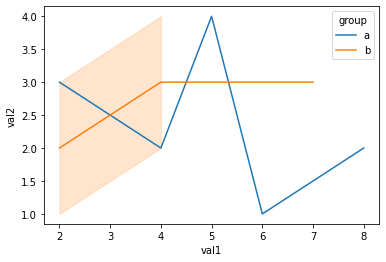

In [61]:
from fugue import FugueWorkflow

with FugueWorkflow() as dag:
    df = dag.df(data.copy())
    df = df.transform(make_new_col)
    df.output(output_plot, params=dict(x_col="val1",y_col="val2"))
    df.show()

### Fugue SQL

,group,val1,val2,val3
0,a,2,3,5
1,a,5,4,9
2,a,8,2,10
3,a,6,1,7
4,a,4,2,6


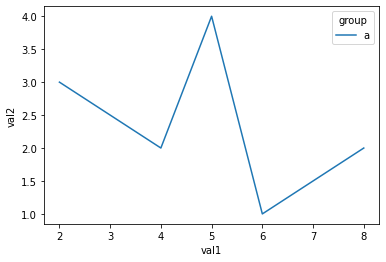

In [62]:
%%fsql
df2 = SELECT *
        FROM data
   TRANSFORM USING make_new_col
   
df3 = SELECT *
        FROM df2
       WHERE group = "a"
       PRINT
       
OUTPUT USING output_plot(x_col="val1",y_col="val2")

**Anonymity for Simplification**

,group,val1,val2,val3
0,a,2,3,5
1,a,5,4,9
2,a,8,2,10
3,a,6,1,7
4,a,4,2,6


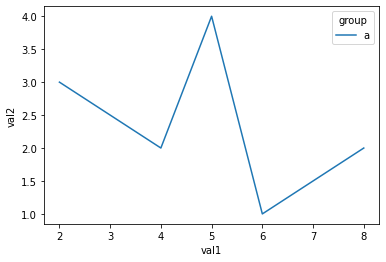

In [63]:
%%fsql
SELECT *
  FROM data
TRANSFORM USING make_new_col
   
SELECT *
 WHERE group = "a"
 PRINT
       
OUTPUT USING output_plot(x_col="val1",y_col="val2")

**fsql Productionizing**

,group,val1,val2
0,a,2,3
1,a,5,4
2,a,8,2
3,a,6,1
4,a,4,2


DataFrames()

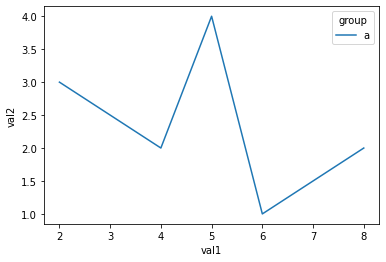

In [64]:
from fugue_sql import fsql
query="""
df2 = SELECT *
        FROM data
   TRANSFORM USING make_new_col
   
df3 = SELECT *
        FROM df2
       WHERE group = "a"
       PRINT
       
OUTPUT USING output_plot(x_col="val1",y_col="val2")
"""
fsql(query).run("spark")

## FugueSQL Python Interoperability

In [65]:
%%fsql
df2 = SELECT *
        FROM data
   TRANSFORM USING make_new_col
   
YIELD DATAFRAME AS new_df


In [66]:
new_df2 = new_df.as_pandas()
new_df2

,group,val1,val2,val3
0,a,2,3,5
1,a,5,4,9
2,a,8,2,10
3,a,6,1,7
4,a,4,2,6
5,b,2,3,5
6,b,4,4,8
7,b,7,3,10
8,b,4,2,6
9,b,2,1,3


In [67]:
%%fsql
SELECT *
  FROM new_df
 WHERE group = 'a'
 PRINT

,group,val1,val2,val3
0,a,2,3,5
1,a,5,4,9
2,a,8,2,10
3,a,6,1,7
4,a,4,2,6


## Benefits of Fugue

* Handles inconsistent behavior between different compute frameworks (Pandas, Spark, and Dask)
* Allows reusability of code across Pandas-sized and Spark-sized data
* Dramatically speeds up testing and lowers total project cost
* Enables new users to be productive with Spark much faster
* Provides a SQL interface capable of handling end-to-end workflows

## PySpark Pandas (Koalas)

In [68]:
import pyspark.pandas as ps

kdf = ps.DataFrame({"a": [None, None, 1, 1, 2, 2], "b": [1, 2, 3, 4, 5, 6]})
kdf.head()

,a,b
0,NaN,1
1,NaN,2
2,1.0,3
3,1.0,4
4,2.0,5


In [69]:
try:
    kdf.groupby("a").max("b")
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/x5/f4r6ylss0k7dwh8c_0dmzd_40000gn/T/ipykernel_42713/774372358.py", line 2, in <module>
    kdf.groupby("a").max("b")
TypeError: max() takes 1 positional argument but 2 were given


In [70]:
kdf.groupby("a").max()

,b
a,
1.0,4
2.0,6


In [71]:
kdf.groupby("a").max().reset_index()

22/03/02 03:19:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/02 03:19:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/02 03:19:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/02 03:19:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,a,b
0,1.0,4
1,2.0,6


**Inconsistent Join Behavior**

In [72]:
kdf = ps.DataFrame({"a": [None, None, 1, 1, 2, 2], "b": [1, 2, 3, 4, 5, 6]})
kdf2 = ps.DataFrame({"a": [None, 1, 2], "c": [1, 2, 3]})
kdf.merge(kdf2, on="a")

22/03/02 03:19:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/02 03:19:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/02 03:19:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/02 03:19:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/02 03:19:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,a,b,c
0,1.0,3,2
1,1.0,4,2
2,2.0,5,3
3,2.0,6,3


In [73]:
df = pd.DataFrame({"a": [None, None, 1, 1, 2, 2], "b": [1, 2, 3, 4, 5, 6]})
df2 = pd.DataFrame({"a": [None, 1, 2], "c": [1, 2, 3]})
df.merge(df2, on="a")

,a,b,c
0,NaN,1,1
1,NaN,2,1
2,1.0,3,2
3,1.0,4,2
4,2.0,5,3
5,2.0,6,3


**Inconsistent Operations**

In [74]:
df.assign(c=df['a'] * df["b"], c_diff=lambda x: x['c'].diff())

,a,b,c,c_diff
0,NaN,1,NaN,NaN
1,NaN,2,NaN,NaN
2,1.0,3,3.0,NaN
3,1.0,4,4.0,1.0
4,2.0,5,10.0,6.0
5,2.0,6,12.0,2.0


In [75]:
try:
    kdf.assign(c=df['a'] * df["b"], c_diff=lambda x: x['c'].diff())
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/x5/f4r6ylss0k7dwh8c_0dmzd_40000gn/T/ipykernel_42713/10798204.py", line 2, in <module>
    kdf.assign(c=df['a'] * df["b"], c_diff=lambda x: x['c'].diff())
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pyspark/pandas/frame.py", line 4903, in assign
    return self._assign(kwargs)
  File "/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/pyspark/pandas/frame.py", line 4915, in _assign
    raise TypeError(
TypeError: Column assignment doesn't support type Series


## Pandas Interfaces

<img src="https://fugue-tutorials.readthedocs.io/_images/pandas_like_3.png" alt="image info" width="800"/>